In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch


def seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [56]:
# 1. CSV 불러오기
df = pd.read_csv("ISCX-VPN-NonVPN_data/Scenario A1-ARFF/Scenario A1-ARFF_15s-VPN.csv")
le = LabelEncoder()
df['class1'] = le.fit_transform(df['class1'])

# 1. CSV 불러오기
df_preprocess = pd.read_csv("preprocessed_data/Scenario A1-ARFF/Scenario A1-ARFF_15s-VPN.csv")
le = LabelEncoder()
df_preprocess['class1'] = le.fit_transform(df_preprocess['class1'])

In [57]:
def corr_remove(df):
    fig, ax = plt.subplots(figsize=(14, 14))

    # 상관관계 히트맵
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
    ax.set_title('Correlation Heatmap')

    plt.tight_layout()
    plt.show()

    remove_col = []

    # 1. 상수값 컬럼
    for col in df.columns:
        if df[col].nunique() <= 1:
            print(f"{col} 는 상수 — 제거 대상")
            remove_col.append(col)

    # 2. class1과 상관관계가 거의 없는 컬럼
    low_corr_features = corr['class1'].abs()[corr['class1'].abs() < 0.1].index.tolist()
    for col in low_corr_features:
        if col not in remove_col:
            print(f"{col} 는 상관관계가 거의 없음 - 제거 대상")
            remove_col.append(col)

    # 3. 상호 상관관계가 0.9 이상인 컬럼 쌍 중 하나 제거
    high_corr_pairs = []
    for i in corr.columns:
        for j in corr.columns:
            if i != j and abs(corr.loc[i, j]) > 0.9:
                pair = tuple(sorted((i, j)))
                if pair not in high_corr_pairs:
                    high_corr_pairs.append(pair)

    # 쌍 중 하나만 제거 (여기선 두 번째 항목 j를 제거)
    for i, j in high_corr_pairs:
        if j not in remove_col:
            print(f"{i} 와 {j} 의 상관관계가 0.9 이상 {j} - 제거 대상")
            remove_col.append(j)

    # 중복 제거
    remove_col = list(set(remove_col))
    remove_col.sort()
    print("최종 제거할 컬럼들:", len(remove_col), remove_col)

    # 4. 실제 삭제
    df_cleaned = df.drop(columns=remove_col)
    return df_cleaned

In [58]:
def train_test(df):
    # 특성과 레이블 나누기
    X = df.drop(columns=['class1'])
    y = df['class1']

    # train/valid/test 분리
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

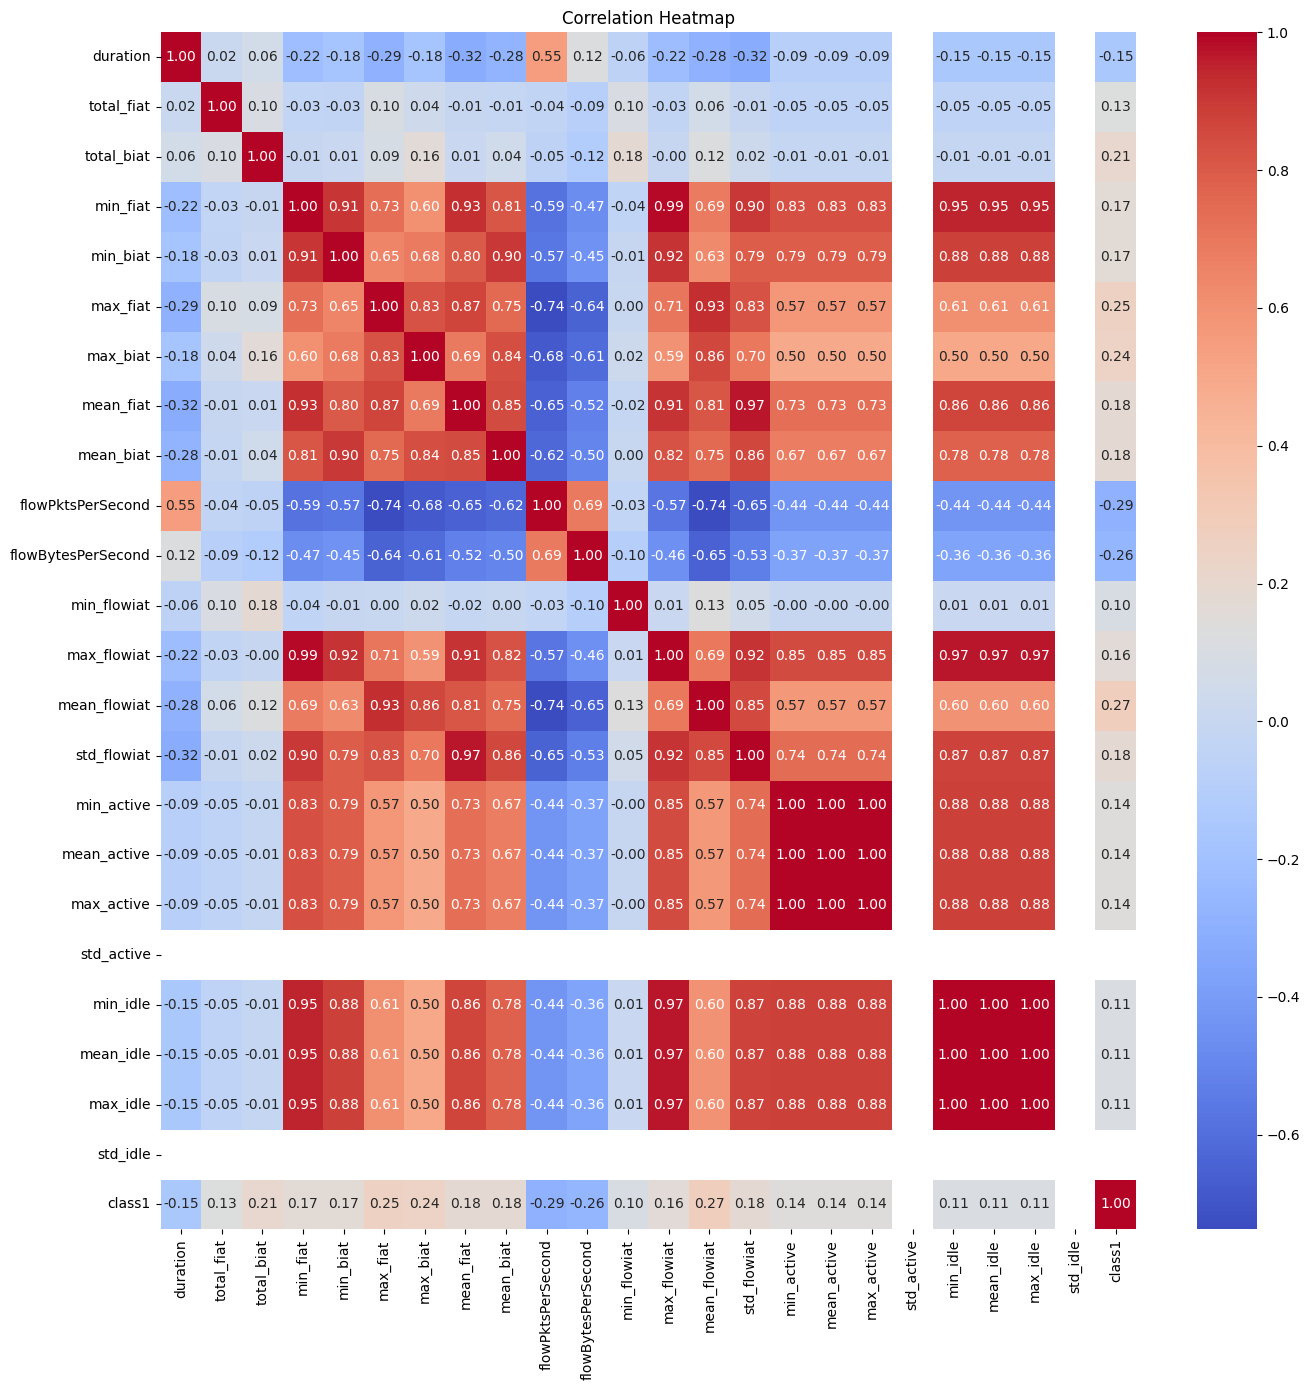

std_active 는 상수 — 제거 대상
std_idle 는 상수 — 제거 대상
min_flowiat 는 상관관계가 거의 없음 - 제거 대상
min_biat 와 min_fiat 의 상관관계가 0.9 이상 min_fiat - 제거 대상
min_fiat 와 min_idle 의 상관관계가 0.9 이상 min_idle - 제거 대상
mean_biat 와 min_biat 의 상관관계가 0.9 이상 min_biat - 제거 대상
max_fiat 와 mean_flowiat 의 상관관계가 0.9 이상 mean_flowiat - 제거 대상
max_flowiat 와 mean_fiat 의 상관관계가 0.9 이상 mean_fiat - 제거 대상
mean_fiat 와 std_flowiat 의 상관관계가 0.9 이상 std_flowiat - 제거 대상
max_flowiat 와 mean_idle 의 상관관계가 0.9 이상 mean_idle - 제거 대상
max_flowiat 와 max_idle 의 상관관계가 0.9 이상 max_idle - 제거 대상
mean_active 와 min_active 의 상관관계가 0.9 이상 min_active - 제거 대상
max_active 와 mean_active 의 상관관계가 0.9 이상 mean_active - 제거 대상
최종 제거할 컬럼들: 13 ['max_idle', 'mean_active', 'mean_fiat', 'mean_flowiat', 'mean_idle', 'min_active', 'min_biat', 'min_fiat', 'min_flowiat', 'min_idle', 'std_active', 'std_flowiat', 'std_idle']


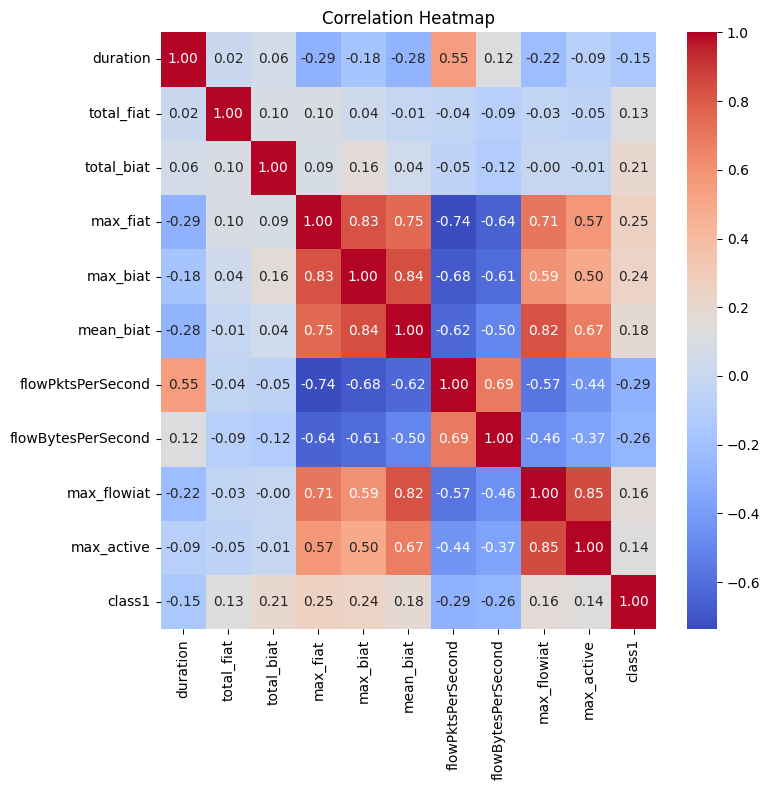

In [59]:
df_preprocess_cleaned = corr_remove(df_preprocess)

fig, ax = plt.subplots(figsize=(8, 8))

# 상관관계 히트맵
corr = df_preprocess_cleaned.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [60]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_test(df_preprocess_cleaned)

# 모델 학습
model = XGBClassifier(eval_metric='logloss', n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50,
)

# 예측 및 평가 (문자 클래스 복원)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.50984
[50]	validation_0-logloss:0.13254
[100]	validation_0-logloss:0.13512
[150]	validation_0-logloss:0.14242
[200]	validation_0-logloss:0.14315
[250]	validation_0-logloss:0.14442
[300]	validation_0-logloss:0.14648
[350]	validation_0-logloss:0.14784
[400]	validation_0-logloss:0.14964
[450]	validation_0-logloss:0.14953
[500]	validation_0-logloss:0.15003
[550]	validation_0-logloss:0.15109
[600]	validation_0-logloss:0.15239
[650]	validation_0-logloss:0.15319
[700]	validation_0-logloss:0.15433
[750]	validation_0-logloss:0.15488
[800]	validation_0-logloss:0.15498
[850]	validation_0-logloss:0.15600
[900]	validation_0-logloss:0.15671
[950]	validation_0-logloss:0.15739
[999]	validation_0-logloss:0.15806
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       378
           1       0.95      0.97      0.96       470

    accuracy                           0.96       848
   macro avg       0.96      0.95      0.96       

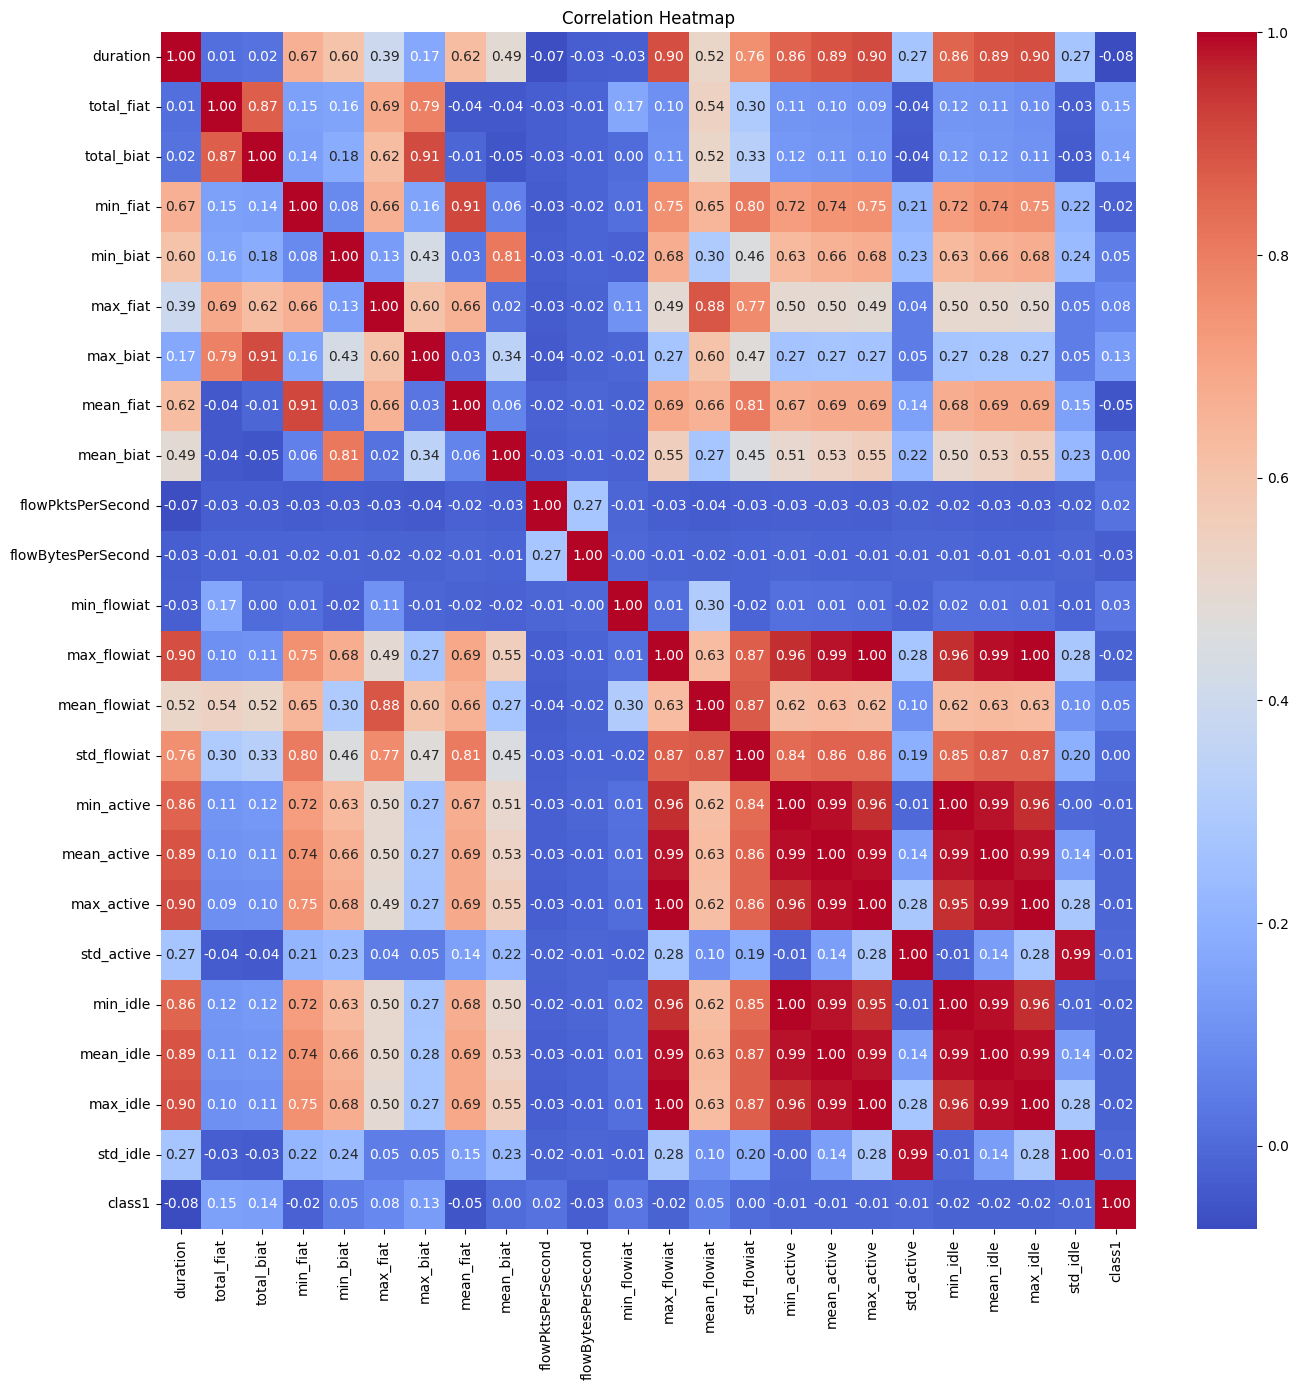

duration 는 상관관계가 거의 없음 - 제거 대상
min_fiat 는 상관관계가 거의 없음 - 제거 대상
min_biat 는 상관관계가 거의 없음 - 제거 대상
max_fiat 는 상관관계가 거의 없음 - 제거 대상
mean_fiat 는 상관관계가 거의 없음 - 제거 대상
mean_biat 는 상관관계가 거의 없음 - 제거 대상
flowPktsPerSecond 는 상관관계가 거의 없음 - 제거 대상
flowBytesPerSecond 는 상관관계가 거의 없음 - 제거 대상
min_flowiat 는 상관관계가 거의 없음 - 제거 대상
max_flowiat 는 상관관계가 거의 없음 - 제거 대상
mean_flowiat 는 상관관계가 거의 없음 - 제거 대상
std_flowiat 는 상관관계가 거의 없음 - 제거 대상
min_active 는 상관관계가 거의 없음 - 제거 대상
mean_active 는 상관관계가 거의 없음 - 제거 대상
max_active 는 상관관계가 거의 없음 - 제거 대상
std_active 는 상관관계가 거의 없음 - 제거 대상
min_idle 는 상관관계가 거의 없음 - 제거 대상
mean_idle 는 상관관계가 거의 없음 - 제거 대상
max_idle 는 상관관계가 거의 없음 - 제거 대상
std_idle 는 상관관계가 거의 없음 - 제거 대상
max_biat 와 total_biat 의 상관관계가 0.9 이상 total_biat - 제거 대상
최종 제거할 컬럼들: 21 ['duration', 'flowBytesPerSecond', 'flowPktsPerSecond', 'max_active', 'max_fiat', 'max_flowiat', 'max_idle', 'mean_active', 'mean_biat', 'mean_fiat', 'mean_flowiat', 'mean_idle', 'min_active', 'min_biat', 'min_fiat', 'min_flowiat', 'min_idle', 'std_active', 'std_fl

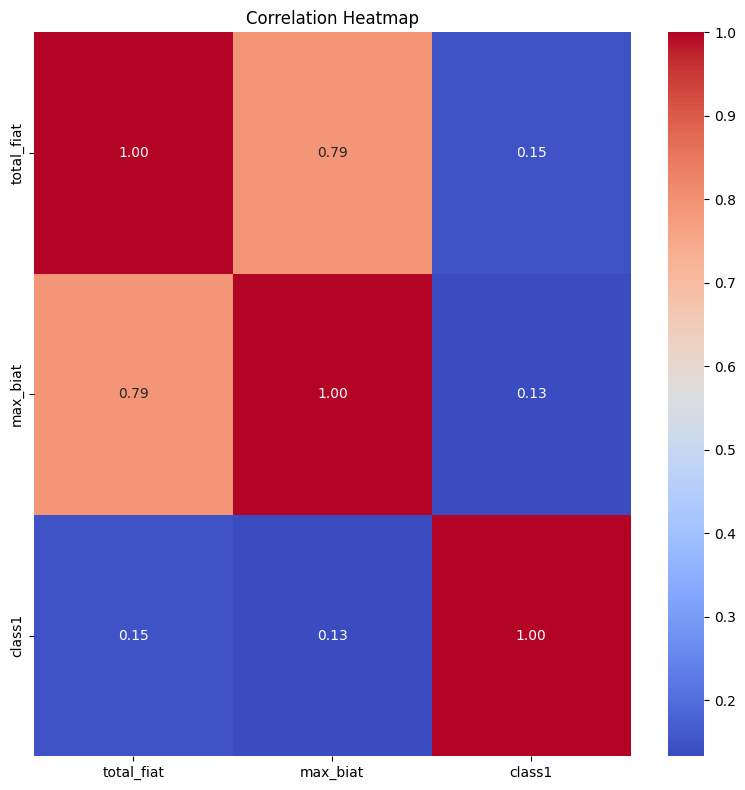

In [61]:
df_cleaned = corr_remove(df)

fig, ax = plt.subplots(figsize=(8, 8))

# 상관관계 히트맵
corr = df_cleaned.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [62]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_test(df_cleaned)

# 모델 학습
model = XGBClassifier(eval_metric='logloss', n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50,
)

# 예측 및 평가 (문자 클래스 복원)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.62485
[50]	validation_0-logloss:0.43846
[100]	validation_0-logloss:0.44052
[150]	validation_0-logloss:0.44634
[200]	validation_0-logloss:0.45622
[250]	validation_0-logloss:0.46358
[300]	validation_0-logloss:0.46717
[350]	validation_0-logloss:0.47185
[400]	validation_0-logloss:0.47847
[450]	validation_0-logloss:0.48465
[500]	validation_0-logloss:0.49090
[550]	validation_0-logloss:0.49594
[600]	validation_0-logloss:0.50222
[650]	validation_0-logloss:0.50699
[700]	validation_0-logloss:0.51019
[750]	validation_0-logloss:0.51611
[800]	validation_0-logloss:0.52223
[850]	validation_0-logloss:0.52559
[900]	validation_0-logloss:0.53002
[950]	validation_0-logloss:0.53514
[999]	validation_0-logloss:0.54057
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1793
           1       0.79      0.73      0.76      1959

    accuracy                           0.76      3752
   macro avg       0.76      0.76      0.76      3